# **LARGE LANGUAGE MODELS (LLMs) GENERATED TEXT DETECTION USING LSTM**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

###**Loading the DAIGT Datasets**

In [ ]:
data1=pd.read_csv("/content/drive/MyDrive/Training_Essay_Data.csv")
data2=pd.read_csv("/content/drive/MyDrive/final_test.csv")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print(data1["generated"].value_counts()) # for checking values.
data1.head()

0    17508
1    11637
Name: generated, dtype: int64


,text,generated
0,Car-free cities have become a subject of incre...,1
1,"Car Free Cities Car-free cities, a concept ga...",1
2,A Sustainable Urban Future Car-free cities ...,1
3,Pioneering Sustainable Urban Living In an e...,1
4,The Path to Sustainable Urban Living In an ...,1


In [ ]:
print(data2["label"].value_counts())
data2.head(3)

0    55845
1    30742
Name: label, dtype: int64


,text,label
0,The Face on Mars is nothing but a natural occu...,0
1,Students have a higher chance of catching a vi...,0
2,Driverless cars have good and bad things that ...,0


In [ ]:
# rename the column names of data2 and data3
data2 = data2.rename(columns={'label': 'generated'})

In [ ]:
data = pd.concat([data1, data2], ignore_index=True)
data.head()

,text,generated
0,Car-free cities have become a subject of incre...,1
1,"Car Free Cities Car-free cities, a concept ga...",1
2,A Sustainable Urban Future Car-free cities ...,1
3,Pioneering Sustainable Urban Living In an e...,1
4,The Path to Sustainable Urban Living In an ...,1


In [ ]:
data.isnull().sum()

text         0
generated    0
dtype: int64

###**Exploratory Data Analysis**

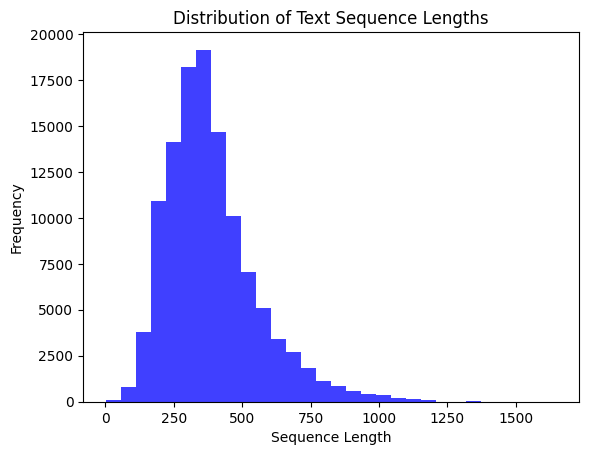

In [ ]:
sequence_lengths = data['text'].apply(lambda x: len(x.split()))

plt.hist(sequence_lengths, bins=30, alpha=0.75, color='blue')
plt.title('Distribution of Text Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

###**Class imbalancement**

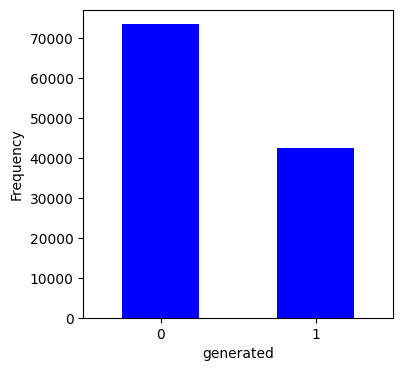

In [ ]:
offer = data['generated']
offer_sum = offer.value_counts()
plt.figure(figsize = (4,4))
offer_sum.plot(kind='bar',color='blue')
plt.xlabel('generated')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

###**Balancing the Classes**

In [ ]:
# Count the occurrences of each class
class_counts = data['generated'].value_counts()

# Find the minority and majority class labels
minority_class_label = class_counts.idxmin()
majority_class_label = class_counts.idxmax()

# Count the difference in occurrences between the two classes
class_difference = class_counts[majority_class_label] - class_counts[minority_class_label]

# Sample from the majority class to match the minority class
data = data.drop(data[data['generated'] == majority_class_label].sample(n=class_difference).index)

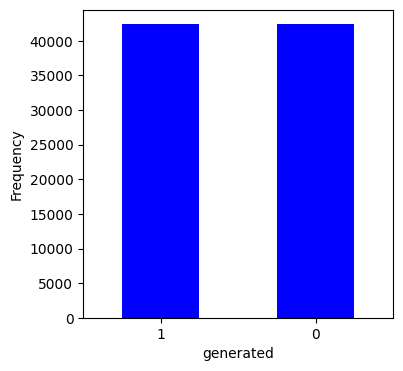

In [ ]:
offer = data['generated']
offer_sum = offer.value_counts()
plt.figure(figsize = (4,4))
offer_sum.plot(kind='bar',color='blue')
plt.xlabel('generated')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

##**Configuration**

In [ ]:
class CFG:
    sequence_length = 1024
    vocab_size = 10000
    is_training = False

##**Text Vectorization**

In [ ]:
# Create a TextVectorization layer with specified parameters
vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=CFG.vocab_size,
    output_sequence_length=CFG.sequence_length,
    pad_to_max_tokens=True
)
# Adapt the TextVectorization layer to the training data
vectorizer.adapt(data["text"], batch_size=1024)

##**Splitting the dataset into training and validation sets**

In [ ]:
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data["generated"], random_state=42)
train_data.shape, test_data.shape

((67806, 2), (16952, 2))

##**Creating tensorflow dataset**

In [ ]:
def create_dataset(dataframe, shuffle=True):
    # Create a TensorFlow dataset from the text and label columns of the dataframe
    dataset = tf.data.Dataset.from_tensor_slices((dataframe["text"], dataframe["generated"]))
    if shuffle:
        # Shuffle the dataset if the shuffle parameter is True
        dataset = dataset.shuffle(1024, reshuffle_each_iteration=True)
    # Batch the dataset into smaller batches of size 256
    dataset = dataset.batch(256).cache().prefetch(tf.data.AUTOTUNE)
    # Prefetch the next batch of data to further optimize training
    return dataset

In [ ]:
train_ds = create_dataset(train_data)
test_ds = create_dataset(test_data, shuffle=False)

##**LSTM Model Development**

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 1024)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 1024, 64)          640000    
                                                                 
 bidirectional (Bidirection  (None, 1024, 128)         66048     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 1024, 128)         0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                        

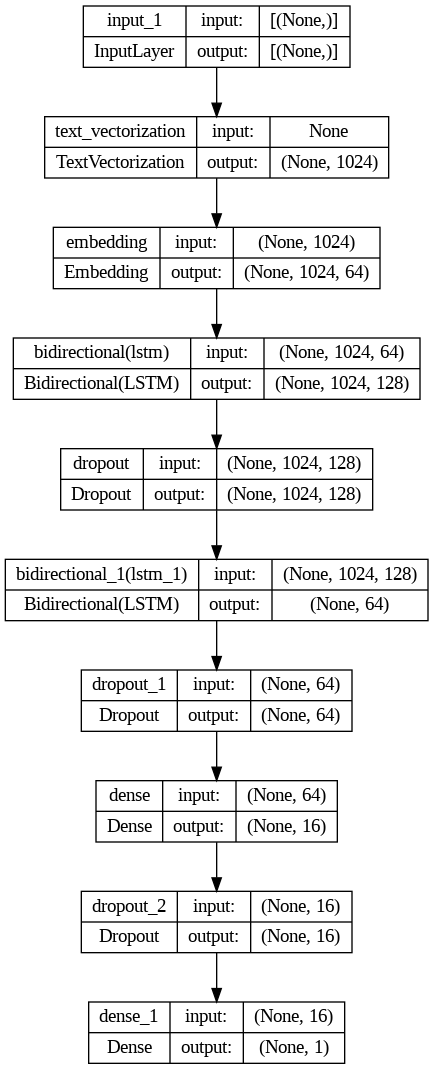

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    vectorizer,
    tf.keras.layers.Embedding(
        input_dim=CFG.vocab_size,
        output_dim=64,
        input_length=CFG.sequence_length,
        mask_zero=True
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc") ])

##**Training the model**

In [ ]:
file_path = "model.tf"

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore weights to the best model
)
history = model.fit(
        train_ds,
        epochs=5,
        validation_data=test_ds,
        callbacks=[
            early_stopping,
            # Save the best model based on validation AUC score
            tf.keras.callbacks.ModelCheckpoint(
                file_path,
                save_best_only=True,
                monitor='val_auc',
                mode='max'
            )])

Epoch 1/5
265/265 [==============================] - 3580s 14s/step - loss: 0.1510 - accuracy: 0.9484 - auc: 0.9861 - val_loss: 0.0304 - val_accuracy: 0.9904 - val_auc: 0.9989
Epoch 2/5
265/265 [==============================] - 3554s 13s/step - loss: 0.0211 - accuracy: 0.9952 - auc: 0.9988 - val_loss: 0.0166 - val_accuracy: 0.9959 - val_auc: 0.9991
Epoch 3/5
265/265 [==============================] - 3438s 13s/step - loss: 0.0136 - accuracy: 0.9969 - auc: 0.9993 - val_loss: 0.0129 - val_accuracy: 0.9963 - val_auc: 0.9994
Epoch 4/5
265/265 [==============================] - 3524s 13s/step - loss: 0.0095 - accuracy: 0.9973 - auc: 0.9997 - val_loss: 0.0126 - val_accuracy: 0.9963 - val_auc: 0.9995
Epoch 5/5
265/265 [==============================] - 3511s 13s/step - loss: 0.0041 - accuracy: 0.9989 - auc: 0.9999 - val_loss: 0.0117 - val_accuracy: 0.9975 - val_auc: 0.9992


In [ ]:
# Load the model
model = tf.keras.models.load_model("model.tf")

##**Model Evaluation During training**

In [ ]:
def plot_learning_curve(history):
  plt.figure(figsize=(12, 8))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='upper right')

  plt.figure(figsize=(12, 8))
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='upper right')

  plt.figure(figsize=(12, 8))
  plt.plot(history.history['auc'])
  plt.plot(history.history['val_auc'])
  plt.title('AUC')
  plt.ylabel('AUC')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='upper right')
  plt.show()
if CFG.is_training:
    plot_learning_curve(history)

##**Model accuracy**

In [ ]:
test_loss, test_accuracy, test_auc = model.evaluate(test_ds)
print(f"Testing Loss: {test_loss: .4f}")
print(f"Testing Accuracy: {test_accuracy: .4f}")
print(f"Testing AUC: {test_auc: .4f}")

# Evaluate the model on training dataset
train_loss, train_accuracy , train_auc = model.evaluate(train_ds)
print(f"Training Loss: {train_loss:.4f}")
print(f"Training Accuracy: {train_accuracy:.4f}")

67/67 [==============================] - 293s 4s/step - loss: 0.0126 - accuracy: 0.9963 - auc: 0.9995
Testing Loss:  0.0126
Testing Accuracy:  0.9963
Testing AUC:  0.9995
265/265 [==============================] - 1022s 4s/step - loss: 0.0031 - accuracy: 0.9991 - auc: 1.0000
Training Loss: 0.0031
Training Accuracy: 0.9991


In [ ]:

# Save the trained model to Google Drive
model.save("/content/drive/My Drive/model.tf")

##**Training Accuracy and Training loss**

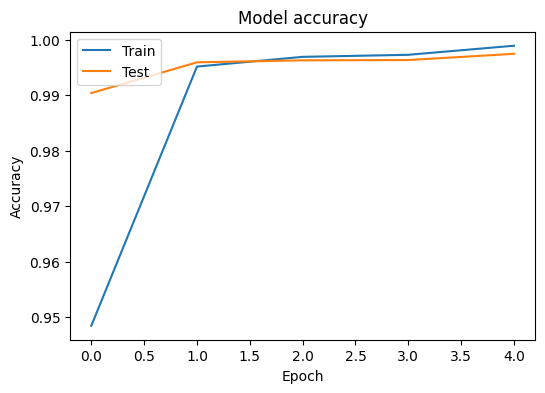

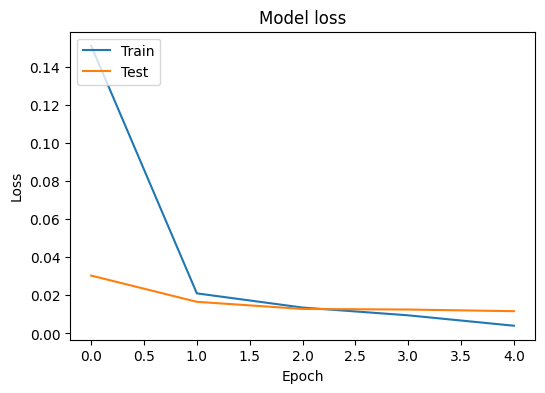

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


##**Confusion Matrix**

67/67 [==============================] - 243s 4s/step


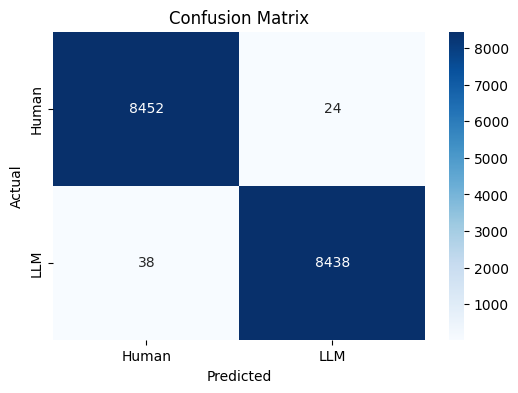

In [ ]:
# Predict probabilities for validation dataset
y_prob = model.predict(test_ds)

# Convert probabilities to class labels (0 or 1)
y_pred = (y_prob > 0.5).astype(int)

# Get true labels from validation dataset
y_true = test_data["generated"].values

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'LLM'], yticklabels=['Human', 'LLM'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()




In [ ]:
# Generate classification report
report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8476
           1       1.00      1.00      1.00      8476

    accuracy                           1.00     16952
   macro avg       1.00      1.00      1.00     16952
weighted avg       1.00      1.00      1.00     16952



In [ ]:
# # Example input text
# ex1 = ["This is an example sentence."]

# # Convert the example input to a TensorFlow dataset
# ex1_ds = tf.data.Dataset.from_tensor_slices(ex1)

# # Preprocess the example input using the TextVectorization layer
# vectorized = vectorizer(ex1_ds)

# # Make prediction using the trained model
# prediction = model.predict(vectorized)

# # Interpret the predictions
# if prediction > 0.5:
#     label = "generated by LLM"
# else:
#     label = "human-generated"

# print("Predicted label:", label)



